In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import display

# read whole year data
allFiles = glob.glob("data/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
df = pd.concat(list_)

In [2]:
selected_features = ['Marketing Code','App Source', 'Web Source', 'Classification','Enquired',
                     'Loan Amount']
target = 'Enquiry Status';
whole_set = selected_features + [target]

df = df[whole_set]
df = df.replace('On Hold','Rejected')
# convert loan amount to number type, and change string to NaN
df['Loan Amount'] = pd.to_numeric(df['Loan Amount'],errors='coerce')
df = df.dropna(axis=0, how='any')

df['Loan Amount'] = df['Loan Amount'].astype(int)

In [3]:
print("Shape of data frame: {}".format(df.shape))
print("Keys of enquiries_dataset: \n{}".format(df.keys()))

Shape of data frame: (47403, 7)
Keys of enquiries_dataset: 
Index(['Marketing Code', 'App Source', 'Web Source', 'Classification',
       'Enquired', 'Loan Amount', 'Enquiry Status'],
      dtype='object')


In [4]:
from datetime import datetime
from dateutil.parser import parse

temp = pd.DatetimeIndex(df['Enquired'])
df['Enquired'] = temp
df['Enquired Date'] = pd.to_datetime(temp.date)
df['Enquired Time'] = temp.time
# data_set = data_set.drop(['Enquired'],1)

# filter years
start_date = '2017-01-01' 
end_date = '2017-12-31'
mask = (df['Enquired Date'] > start_date) & (df['Enquired Date'] <= end_date)
df = df.loc[mask].reset_index(drop=True)
df['day_of_week'] = df['Enquired Date'].dt.weekday_name

# X = data_set[['Marketing Code','App Source', 'Web Source', 'Classification','Enquired Date',]]
X = df[df.keys()]
X = X.drop(['Enquiry Status'],1)
y = df[target]

In [5]:
def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

In [6]:
print("List of data types: \n{}".format(df.dtypes))

List of data types: 
Marketing Code            object
App Source                object
Web Source                object
Classification            object
Enquired          datetime64[ns]
Loan Amount                int64
Enquiry Status            object
Enquired Date     datetime64[ns]
Enquired Time             object
day_of_week               object
dtype: object


In [7]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import make_pipeline

# pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))
# pipe_lr.fit(X_train, y_train)
# y_pred = pipe_lr.predict(X_test)
# print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col].astype(str))
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [8]:
from sklearn.preprocessing import LabelEncoder
# feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

le = LabelEncoder()


data_set = MultiColumnLabelEncoder(columns = encoded_df.keys()).fit_transform(data_set)

# Categorial feature ecoding
X = MultiColumnLabelEncoder(columns = X.keys()).fit_transform(X)
y = le.fit_transform(y)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)

# Get idxs of columns to keep
idxs_selected = model.get_support(indices=True)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3,
                     stratify=y,
                     random_state=0)

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/Us

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data w

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data w

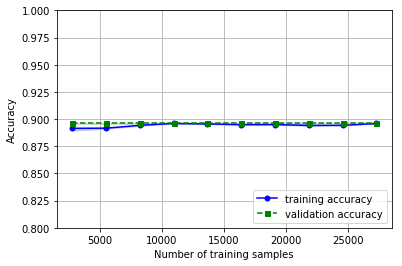

Test Accuracy: 0.896


/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import learning_curve
from sklearn import svm

pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklear

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data w

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data w

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data w

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data w

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data w

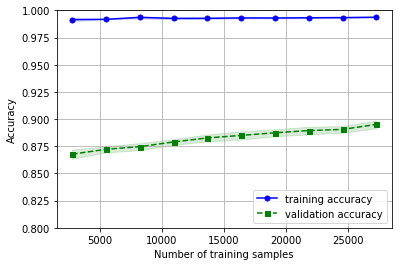

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Test Accuracy: 0.896


/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
from sklearn.ensemble import RandomForestClassifier

pipe_rn = make_pipeline(StandardScaler(),PCA(n_components=2),RandomForestClassifier(random_state=1))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_rn,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

pipe_rn.fit(X_train, y_train)
y_rn_pred = pipe_rn.predict(X_test)
print('Test Accuracy: %.3f' % pipe_rn.score(X_test, y_test))

In [13]:
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


scores = cross_validation.cross_val_score(pipe_lr, X_new, y, cv=3)
print("cross_validation: {:.2f}".format(np.mean(scores, axis=0)))
print("f1 score: {:.2f}".format(f1_score(y_test, y_pred,average='weighted')))
print("precision score: {:.2f}".format(precision_score(y_test, y_pred, average='weighted')))

print()
scores = cross_validation.cross_val_score(pipe_rn, X_new, y, cv=3)
print("cross_validation: {:.2f}".format(np.mean(scores, axis=0)))
print("f1 score: {:.2f}".format(f1_score(y_test, y_rn_pred,average='weighted')))
print("precision score: {:.2f}".format(precision_score(y_test, y_rn_pred, average='weighted')))
# print()

# scores = cross_validation.cross_val_score(pipe_svm, X_new, y, cv=3)
# print("cross_validation: {:.2f}".format(np.mean(scores, axis=0)))
# print("f1 score: {:.2f}".format(f1_score(y_test, svm_y_pred,average='weighted')))
# print("precision score: {:.2f}".format(precision_score(y_test, svm_y_pred, average='weighted')))

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: Un

cross_validation: 0.90
f1 score: 0.85
precision score: 0.80



/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


cross_validation: 0.82
f1 score: 0.88
precision score: 0.88


/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

# rescale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rfc = RandomForestClassifier(n_estimators=500,random_state=1)
rfc.fit(X_train_scaled, y_train)
pred_forest = rfc.predict(X_test)

print("Test score: {:.2f}".format(rfc.score(X_test_scaled, y_test)))


/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Test score: 0.93


 1) Loan Amount                    0.221398
 2) Enquired Time                  0.187529
 3) Enquired                       0.184027
 4) Marketing Code                 0.117020
 5) Enquired Date                  0.110208
 6) App Source                     0.070403
 7) Classification                 0.054756
 8) day_of_week                    0.054574
 9) Web Source                     0.000084


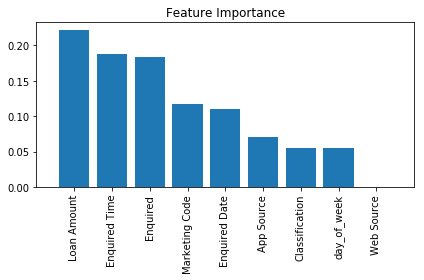

In [15]:
feat_labels = X.columns[0:]
importances = rfc.feature_importances_

# reverse the list
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [16]:
# input_x = df.iloc[:]
# input_x_test = df.iloc[:,idxs_selected]

# input_x_test = MultiColumnLabelEncoder(columns = input_x_test.keys()).fit_transform(input_x_test)
# input_x_test = scaler.fit_transform(input_x_test)

# result = rfc.predict(input_x_test)
# result = le.inverse_transform(result)
# proba = rfc.predict_proba(input_x_test)   
# proba = [np.max(p) for p in proba]

In [17]:
# input_x = input_x.assign(predict=result.tolist())
# input_x = input_x.assign(possibility=proba)
# input_x.to_csv('example_pipeline.csv')

In [23]:
# import pickle
# import os

# dest = os.path.join('movieclassifier', 'pkl_objects')
# if not os.path.exists(dest):
#     os.makedirs(dest)

# pickle.dump(stop,open(os.path.join(dest, 'stopwords.pkl'),'wb'),protocol=4)
# pickle.dump(clf,
            
from sklearn.externals import joblib
joblib.dump(pipe_lr, 'app/models/lrpipeline.pkl')

['app/models/lrpipeline.pkl']

In [26]:
model_columns = list(X.columns)
joblib.dump(model_columns, 'app/models/model_columns.pkl')

['app/models/model_columns.pkl']